In [1]:
# from datasets import load_dataset
from fastai.vision.all import *
from PIL import Image
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
# from concept_helpers.concept_deepview import DeepViewConcept
# from xplique.concepts import CraftTorch as Craft
from concept_helpers.DeepView_Craft import CraftTorchDV as Craft
from concept_helpers.DeepView_Craft import CraftTorchSupervisedShared as CraftSS
from concept_helpers.DeepView_Craft import CraftTorchSupervised as CraftS
from concept_helpers.combined_crafts import CombinedCrafts , CraftSAE
from xplique.attributions.global_sensitivity_analysis import HaltonSequenceRS, JansenEstimator

from xplique.concepts.craft_torch import _batch_inference

import urllib.request
import numpy as np
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
import timm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.sparse.linalg import eigs
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

import numpy as np
import itertools
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, adjusted_rand_score, rand_score,
                            normalized_mutual_info_score, adjusted_mutual_info_score)
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from concept_helpers.disc_nmf import RSNMF

from sklearn.cluster import KMeans
import random
import torchvision.transforms.functional as F
import random
from DriftLocalization.j_helper_functions import uncertainty_matrices, entropy_uncertainty

from experiment_helpers.experiment_helper_functions import *

# from deepview.evaluate import evaluate_umap
# from deepview.evaluate import leave_one_out_knn_dist_err


device = 'cuda' 
# loading any timm model
model = timm.create_model('nf_resnet50.ra2_in1k', pretrained=True)
model = model.to(device)
# train_images, train_labels, val_images, val_labels, model = load_imagenette()

# processing
config = resolve_data_config({}, model=model)
transform = create_transform(**config)
to_pil = transforms.ToPILImage()

# cut the model in twop arts (as explained in the paper)
# first part is g(.) our 'input_to_latent' model, second part is h(.) our 'latent_to_logit' model
# g = nn.Sequential(*(list(model.children())[:4]))  # input to penultimate layer
# h = nn.Sequential(*(list(model.children())[4:]))  # penultimate layer to logits

g = nn.Sequential(*(list(model.children())[:4]))  # input to penultimate layer
# h = nn.Sequential(*(list(model.children())[4:]))
classifier_head = ClassifierHead(in_features=2048, out_features=10)
classifier_head = classifier_head.to(device)
classifier_head.load_state_dict(torch.load("models/imagewoof_classifier_head.pth"))

with urllib.request.urlopen('https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt') as f:
    imagenet_class_names = np.array(f.read().decode('utf-8').split('\n'))


def gen_images(filelist):
    for f in filelist:
        folder_name = f.split('/')[-2]
        class_id = folder_name2class_id[folder_name]
        im = Image.open(f)
        if len(im.getbands()) == 3:
            yield np.array(im.resize((224, 224))), class_id
# Load imagenette dataset
imagewoof_folder = untar_data(URLs.IMAGEWOOF_160)

folders_names = ['n02086240', 'n02087394', 'n02088364', 'n02089973', 'n02093754', 'n02096294', 'n02099601',
                 'n02105641', 'n02111889', 'n02115641']

imagewoof_class_ids = list(range(0, 10))
folder_name2class_id = dict(zip(folders_names, imagewoof_class_ids))

# Get file lists for train, val, and test sets
# train_filelist = glob.glob(f'{imagewoof_folder}/train/*/*.JPEG')
val_filelist = glob.glob(f'{imagewoof_folder}/val/*/*.JPEG')
# test_filelist = glob.glob(f'{imagenette_folder}/test/*/*.JPEG')

# Preprocess train, validation, and test sets in batches
# train_images, train_labels = preprocess_images_in_batches(train_filelist)
val_images, val_labels = preprocess_images_in_batches(val_filelist,gen_images, transform, to_pil)

def gen_images(filelist,folder_names,folder_name2class_id):
        for f in filelist:
            
            folder_name = f.split('/')[-2]
            if folder_name in folder_names:
                class_id = folder_name2class_id[folder_name]
                im = Image.open(f)
                if len(im.getbands()) == 3:
                    yield np.array(im.resize((224, 224))), class_id

# ood_folder = '/home/iroberts/projects/concepts_deepview/data/ninco_all/NINCO/NINCO_OOD_classes'
# # ood_folder = '/home/iroberts/projects/concepts_deepview/data/NINCO_all/NINCO/NINCO_popular_datasets_subsamples'

# ood_folder_names = ['french_fries','donuts','waffles','glass_of_milk','cup_cakes','chicken_quesadilla']#, 'donuts'] #'grey_fox', 'Arctic_fox']
# ood_class_names = ['french_fries','donuts','waffles','glass_of_milk','cup_cakes','chicken_quesadilla']#, 'donuts'] #'grey fox', 'Arctic fox']

ood_folder = '/home/robertsi20/PycharmProjects/Concepts/concepts_deepview/data/NINCO/NINCO_OOD_classes'
        
ood_folder_names = os.listdir(ood_folder)
ood_class_names = ood_folder_names

ood_class_ids = [i+1000 for i,class_name in enumerate(ood_class_names)]
ood_folder_name2class_id = dict(zip(ood_folder_names, ood_class_ids))
ood_filelist = glob.glob(f'{ood_folder}/*/*.jpg')
# print(ood_filelist)

ood_images, ood_labels = zip(*gen_images(ood_filelist,ood_folder_names,ood_folder_name2class_id))
ood_images, ood_labels = np.array(ood_images), np.array(ood_labels)
ood_preprocessed_images = torch.stack([transform(to_pil(img)) for img in ood_images], 0)

def full_wrapper(x):
    with torch.no_grad():
        x = np.array(x, dtype=np.float32)
        tensor = torch.from_numpy(x).to(device)
        latent = g(tensor)
        pred = h(latent).cpu().numpy()
    return pred
def latent_wrapper(x):
    with torch.no_grad():
        x = np.array(x, dtype=np.float32)
        tensor = torch.from_numpy(x).to(device)
        latent = g(tensor).cpu().numpy()
            # pred = h(tensor).cpu().numpy()
    return latent

def process_in_batches(data, batch_size, func):
    """
    Process data in batches using the full_wrapper function.

    Args:
        data (np.ndarray): Input data to process.
        batch_size (int): Size of each batch.

    Returns:
        np.ndarray: Predictions for the entire dataset.
    """
    # Initialize an empty list to store predictions
    all_preds = []

    # Iterate over the data in batches
    for start_idx in range(0, len(data), batch_size):
        # Get the end index for the current batch
        end_idx = min(start_idx + batch_size, len(data))
        # Get the current batch
        batch = data[start_idx:end_idx]
        # Use full_wrapper to process the batch and get predictions
        batch_preds = func(batch)
        # Append the predictions to the list
        all_preds.append(batch_preds)

    # Concatenate all batch predictions into a single numpy array
    all_preds = np.concatenate(all_preds, axis=0)
    return all_preds
    
def predict_with_uncertainty_batched(f_model, data_loader, n_iter=10, device="cpu"):
    """
    Perform N stochastic forward passes over batches of data and return predictions.

    Args:
        f_model (nn.Module): The model with dropout layers.
        data_loader (DataLoader): DataLoader for the dataset.
        n_iter (int): Number of stochastic forward passes.
        device (str): Device to perform computations on ('cpu' or 'cuda').

    Returns:
        torch.Tensor: Predictions of shape (n_iter, num_data, num_classes).
    """
    # f_model.train()  # Ensure dropout is active during inference
    
    # Store predictions for all iterations
    all_preds = []
    for _ in range(n_iter):
        preds = []
        for inputs,_ in data_loader:
            with torch.no_grad():
                batch_preds = torch.softmax(f_model(inputs),dim=1)
                
            preds.append(batch_preds)
        # Concatenate predictions for this iteration
        all_preds.append(torch.cat(preds, dim=0))
    
    # Stack predictions across iterations
    return torch.stack(all_preds, dim=0)

from sklearn.decomposition import non_negative_factorization


def predict_with_uncertainty_batched_sig(f_model, data_loader, n_iter=10, device="cpu"):
    """
    Perform N stochastic forward passes over batches of data and return predictions.

    Args:
        f_model (nn.Module): The model with dropout layers.
        data_loader (DataLoader): DataLoader for the dataset.
        n_iter (int): Number of stochastic forward passes.
        device (str): Device to perform computations on ('cpu' or 'cuda').

    Returns:
        torch.Tensor: Predictions of shape (n_iter, num_data, num_classes).
    """
    # f_model.train()  # Ensure dropout is active during inference
    
    # Store predictions for all iterations
    all_preds = []
    for _ in range(n_iter):
        preds = []
        for inputs in data_loader:
            with torch.no_grad():
                batch_preds = torch.softmax(f_model(inputs),dim=1)
                
            preds.append(batch_preds)
        # Concatenate predictions for this iteration
        all_preds.append(torch.cat(preds, dim=0))
    
    # Stack predictions across iterations
    return torch.stack(all_preds, dim=0)
    

def compute_predictions_sigmoid(inputs):
    # tree_predictions = []
    # for tree in model.estimators_:
    #     tree_predictions.append(tree.predict_proba(inputs))
    
    # tree_predictions = np.array(tree_predictions)
    
    # embeddings = process_in_batches(preprocessed_images,32, latent_wrapper,g).to(device)
    inputs = inputs.to(device)
    data_loader = torch.utils.data.DataLoader(inputs, batch_size=64)
    
    predictions = predict_with_uncertainty_batched_sig(stochastic_model, data_loader, n_iter=20, device=device)

    predictions =  predictions.cpu().numpy()
    
    a,prob_mat = uncertainty_matrices(predictions)
    t,e,a = entropy_uncertainty(prob_mat)
    sig_threshold, _, t_norm = get_threshold(t)
    loc = UncertaintyWrapperWithSigmoid(sig_threshold)

    unc_pred_probs = loc.predict_proba(t_norm)
    unc_preds = np.argmax(unc_pred_probs, axis=1)
    return unc_preds, unc_pred_probs

def activation_transform(inputs, patches=False, labels=None, activations=None, n_patches=16):
    """
    Transforms the input images into an (N, 320) representation where N is the number of images.
    
    Parameters:
    - inputs: Input images or data to be transformed.
    - patches: Whether to use patches (if needed for some other functionality).
    - labels: Optional labels for the inputs.
    - activations: Optional pre-computed activations. If None, activations are computed.
    - drift_basis: Predefined basis for NMF.
    - n_patches: Number of patches per image (default is 16).
    
    Returns:
    - transformed_data: Transformed dataset with shape (N, 320).
    """
    
    # Step 1: Extract latent activations using drift_craft
    A = inputs#drift_craft._latent_predict(inputs)  # Assuming A.shape = (N, H, W, D) where D is the activation dimension
    # print(A.shape)
    # Step 2: Reshape activations to 2D (flatten the spatial dimensions)
    original_shape = A.shape[:-1]  # Keep original shape to reconstruct later
    re_activations = np.reshape(A, (-1, A.shape[-1]))
    # print(re_activations.shape)# Flatten to (N * H * W, D)
    # print(re_activations.shape)
    # Step 3: Apply Non-negative Matrix Factorization (NMF) to reduce dimensionality
    
    embedding, basis, n_iter = non_negative_factorization(np.array(re_activations),
                                                          n_components=len(unc_basis),
                                                          init='custom',
                                                          update_H=False, solver='mu', H=unc_basis)

    embedding = np.reshape(embedding, (*original_shape, embedding.shape[-1]))
    # print(embedding.shape)
    
    # Step 4: Reshape the embedding back to the original shape (N, n_patches, n_components)
    # N = 1 # Number of images
    # n_components = embedding.shape[-1]  # Number of concepts (after NMF reduction)
    
    # embedding_reshaped = np.reshape(embedding, (N, n_patches, n_components))  # Reshape back to (N, n_patches, n_components)
    
    # # Step 5: Tile the concepts for each patch to create (N, 320) dataset
    # # Since we need 320 dimensions (n_patches * n_components), we flatten the patches and their concepts
    # transformed_data = embedding_reshaped.reshape(N, -1)  # Shape (N, n_patches * n_components), e.g. (N, 320)

    return embedding
    
def estimate_importance_helper_sigmoid(inputs: np.ndarray = None, class_of_interest: int = None,
                                     nb_design: int = 32, compute_class_importance: bool = False) -> np.ndarray:
        """
        Estimates the importance of each concept for a given class, either globally
        on the whole dataset provided in the fit() method (in this case, inputs shall
        be set to None), or locally on a specific input image.

        Parameters
        ----------
        inputs : numpy array or Tensor
            The input data on which to compute the importances.
            If None, then the inputs provided in the fit() method
            will be used (global importance of the whole dataset).
            Default is None.
        nb_design
            The number of design to use for the importance estimation. Default is 32.

        Returns
        -------
        importances
            The Sobol total index (importance score) for each concept.

        """
        
        coeffs_u = activation_transform(inputs.permute((0,2,3,1)).cpu().numpy())
        # print(coeffs_u.shape)
        # coeffs_u = sigmoidunc_craft.transform(inputs)
        

        masks = HaltonSequenceRS()(len(unc_basis), nb_design=nb_design)
        estimator = JansenEstimator()
        importances = []

        if len(coeffs_u.shape) == 4:
            
            # for coeff in coeffs_u:
            # apply a re-parameterization trick and use mask on all localization for a given
            # concept id to estimate sobol indices
            for coeff in coeffs_u:
                u_perturbated = masks[:, None, None, :] * coeff[None, :]

                a_perturbated = np.reshape(u_perturbated,
                                           (-1, coeff.shape[-1])) @ unc_basis
                # print("a_perturbed", a_perturbated.shape)
                a_perturbated = np.reshape(a_perturbated,
                                           (len(masks), coeffs_u.shape[1], coeffs_u.shape[2], -1))
                # print("a_perturbed-re", torch.from_numpy(a_perturbated).shape)

                # a_perturbated: (N, H, W, C)
                _,y_pred = compute_predictions_sigmoid(torch.from_numpy(a_perturbated).permute((0,3,1,2)))
                # print("preds",y_pred.shape)

                y_pred = y_pred[:, class_of_interest]
                
                stis = estimator(masks, y_pred, nb_design)

                importances.append(stis)
        
        importances = np.mean(importances, 0)

        # # Save the results of the computation if working on the whole dataset
        if compute_class_importance:
            most_important_concepts = np.argsort(importances)[::-1]
            sigmoidunc_craft.sensitivities[class_of_interest] = Sensitivity(importances, most_important_concepts,
                                                                     cmaps=plt.get_cmap('tab20b').colors + plt.get_cmap('Set3').colors) 

        return importances

def nmf_transform(inputs,drift_basis, patches=False, labels=None, activations=None, n_patches=16):
    """
    Transforms the input images into an (N, 320) representation where N is the number of images.
    
    Parameters:
    - inputs: Input images or data to be transformed.
    - patches: Whether to use patches (if needed for some other functionality).
    - labels: Optional labels for the inputs.
    - activations: Optional pre-computed activations. If None, activations are computed.
    - drift_basis: Predefined basis for NMF.
    - n_patches: Number of patches per image (default is 16).
    
    Returns:
    - transformed_data: Transformed dataset with shape (N, 320).
    """
   
    # Step 1: Extract latent activations using drift_craft
    A = np.mean(inputs, axis=(1,2))#drift_craft._latent_predict(inputs)  # Assuming A.shape = (N, H, W, D) where D is the activation dimension
    # Step 2: Reshape activations to 2D (flatten the spatial dimensions)
   # Step 2: Reshape activations to 2D (flatten the spatial dimensions)
    # original_shape = A.shape[:-1]  # Keep original shape to reconstruct later
    # re_activations = np.reshape(A, (-1, A.shape[-1]))
    # print(re_activations.shape)
    # Step 3: Apply Non-negative Matrix Factorization (NMF) to reduce dimensionality
    embedding, basis, n_iter = non_negative_factorization(A,
                                                          n_components=len(drift_basis),
                                                          init='custom',
                                                          update_H=False, solver='mu', H=drift_basis)
    # print(embedding.shape)
    

    return embedding

import torchvision.transforms.functional as F

# Blurring function
def blurring(images, probability=0.5, kernel_size=None, sigma=None, 
             possible_kernels=[11, 13, 15, 17, 19, 21, 23, 25, 27]):    
    if kernel_size is None:
        kernel_size = random.choice(possible_kernels)
    if sigma is None:
        sigma = np.random.randint(0, 100)

    # Create a mask
    iid_noise_mask = torch.tensor([random.random() < probability for _ in range(images.shape[0])])

    # Apply blurring
    noisy_images = torch.stack([
        F.gaussian_blur(img, kernel_size, sigma) if iid_noise_mask[i] else img
        for i, img in enumerate(images)
    ])
    return noisy_images, iid_noise_mask

# Salt-and-pepper noise function
def salt_n_pepper(images, probability=0.5, pepper_prob=0.2, salt_prob=0.2): 
    iid_noise_mask = torch.tensor([random.random() < probability for _ in range(images.shape[0])])

    # Apply salt-and-pepper noise
    noisy_images = torch.stack([
        torch.where(torch.rand_like(img) < salt_prob, torch.tensor(1.0), 
                    torch.where(torch.rand_like(img) < pepper_prob, torch.tensor(0.0), img))
        if iid_noise_mask[i] else img
        for i, img in enumerate(images)
    ])
    return noisy_images, iid_noise_mask

# Gaussian noise function
def gaussian_noise(images, probability=0.5, mean=0, std=0.2):
    iid_noise_mask = torch.tensor([random.random() < probability for _ in range(images.shape[0])])

    # Apply Gaussian noise
    noisy_images = torch.stack([
        torch.clamp(img + (torch.randn_like(img) * std + mean), 0, 1) if iid_noise_mask[i] else img
        for i, img in enumerate(images)
    ])
    return noisy_images, iid_noise_mask

# Function to apply mixed noise
def apply_mixed_noise(images, blur_prob=0.5, sp_prob=0.5, gauss_prob=0.5, global_prob=0.75):
    """
    Applies a random combination of blurring, salt-and-pepper, and Gaussian noise to images.
    
    Each image has a `global_prob` chance to receive noise.
    Within that, each type of noise (blur, salt-and-pepper, Gaussian) is applied independently.
    """
    # Create masks for each type of noise
    apply_noise_mask = torch.tensor([random.random() < global_prob for _ in range(images.shape[0])])
    apply_blur_mask = torch.tensor([random.random() < blur_prob for _ in range(images.shape[0])])
    apply_sp_mask = torch.tensor([random.random() < sp_prob for _ in range(images.shape[0])])
    apply_gauss_mask = torch.tensor([random.random() < gauss_prob for _ in range(images.shape[0])])

    # Start with the original images
    noisy_images = images.clone()

    # Apply Blurring
    if apply_blur_mask.any():
        blurred_images, blur_mask = blurring(images, probability=apply_blur_mask.float())
        noisy_images[apply_blur_mask] = blurred_images[apply_blur_mask]
        final_mask |= blur_mask

    # Apply Salt-and-Pepper Noise
    if apply_sp_mask.any():
        sp_images, sp_mask = salt_n_pepper(images, probability=apply_sp_mask.float())
        noisy_images[apply_sp_mask] = sp_images[apply_sp_mask]
        final_mask |= sp_mask

    # Apply Gaussian Noise
    if apply_gauss_mask.any():
        gauss_images, gauss_mask = gaussian_noise(images, probability=apply_gauss_mask.float())
        noisy_images[apply_gauss_mask] = gauss_images[apply_gauss_mask]
        final_mask |= gauss_mask

    return noisy_images, final_mask
 


2025-02-24 11:18:59.872477: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-24 11:18:59.881347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740392339.892581  822831 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740392339.895907  822831 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 11:18:59.907409: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

In [ ]:
noise_types = ['blurred', 'salt_n_pepper', 'gaussian','mixed', 'mixed_r']

# Define k values
percentages = np.arange(5, 100, 5)
runs = 1  # Number of runs per noise type

noise_types = ['blurred']#, 'salt_n_pepper', 'gaussian']
all_results = {noise: {
    "total": [], "aleatoric": [], "epistemic": [], "sorted_imp_concepts_percentage": [], 
    "sorted_nmf_concepts_percentage": []
} for noise in noise_types}

# Run multiple times and collect results
for noise_type in noise_types:
    for _ in range(runs):
    
    
        
        ood_sample = np.random.choice(len(ood_preprocessed_images),125,False)
        sample_ood_preprocessed_images = ood_preprocessed_images[ood_sample]
        sample_ood_labels = ood_labels[ood_sample]
        
        sample = np.random.choice(len(val_images),1000,False )
        sample_val_images = val_images[sample]
        sample_val_labels = val_labels[sample]
        
        
        
        # Assuming val_images is a batch of images (N, C, H, W)
        # Example: Create a random batch of images
        # val_images = torch.rand(8, 3, 256, 256)  # (Batch of 8 images)
        
        # Define parameters for Gaussian blur
        if noise_type == 'blurred':
           noisy_iid_images,iid_noise_mask = blurring(sample_val_images, probability=0.25, kernel_size=21, sigma=10, 
                                                         possible_kernels=[11, 13, 15, 17, 19, 21, 23, 25, 27])
        if noise_type == 'blurred_r':
           noisy_iid_images,iid_noise_mask = blurring(sample_val_images, probability=.25, kernel_size=None, sigma=None, 
                                                         possible_kernels=[11, 13, 15, 17, 19, 21, 23, 25, 27])
        if noise_type == 'salt_n_pepper':
            noisy_iid_images,iid_noise_mask = salt_n_pepper(sample_val_images, probability=0.25, pepper_prob=0.3, salt_prob=0.3)
        
        if noise_type == 'salt_n_pepper_r':
            noisy_iid_images,iid_noise_mask = salt_n_pepper(sample_val_images, probability=0.25, pepper_prob=random.random(), salt_prob=random.random())
        
        if noise_type == 'gaussian':
            noisy_iid_images,iid_noise_mask = gaussian_noise(sample_val_images, probability=0.25, mean=0, std=1.5)
        
        if noise_type == 'gaussian_r':
            noisy_iid_images,iid_noise_mask = gaussian_noise(sample_val_images, probability=0.25, mean=random.random(), std=random.random())
        
        if noise_type == 'mixed':
            noisy_iid_images,iid_noise_mask = apply_mixed_noise(sample_val_images, blur_prob=0.25, sp_prob=0.25, gauss_prob=0.25, global_prob=0.25)
        
        if noise_type == 'mixed_r':
            noisy_iid_images,iid_noise_mask = apply_mixed_noise(sample_val_images, blur_prob=random.random(), sp_prob=random.random(), 
                                                                gauss_prob=random.random(), global_prob=0.25)
        
        
        
        # Step 3: Concatenate IID and OOD data
        idd_embeddings = process_in_batches(noisy_iid_images, 64, latent_wrapper)
        
        ood_embeddings = process_in_batches(sample_ood_preprocessed_images, 64, latent_wrapper)
        
        all_embeddings = torch.cat([torch.from_numpy(idd_embeddings),torch.from_numpy(ood_embeddings)]).to(device)
        all_images = torch.cat([noisy_iid_images, sample_ood_preprocessed_images]).to(device)
        all_labels = torch.from_numpy(np.concatenate([sample_val_labels, sample_ood_labels])).to(device)
        
        # Step 4: Create a full noise mask that extends to OOD images (which are never noisy)
        full_noise_mask = torch.cat([
            iid_noise_mask,  # This marks noisy IID images
            torch.zeros(sample_ood_preprocessed_images.shape[0], dtype=torch.bool)  # OOD images are never noisy
        ])
        
        # Step 5: Shuffle all data while keeping track of noise
        shuffle_indices = torch.randperm(all_images.shape[0])
        
        shuffled_embeddings = all_embeddings[shuffle_indices]
        shuffled_images = all_images[shuffle_indices]
        shuffled_labels = all_labels[shuffle_indices]
        shuffled_noise_mask = full_noise_mask[shuffle_indices]  # Tracks noisy images after shuffling
        
        idd_odd_og_labels = shuffled_labels.cpu().numpy()
        
        
        ood_ind = np.where(idd_odd_og_labels > 999)[0]
        idd_ind = np.where(idd_odd_og_labels <= 999)[0]
        
        idd_odd_labels = idd_odd_og_labels.copy()
        idd_odd_labels[ood_ind] = np.random.choice(np.unique(val_labels), size=len(ood_ind))
        gt_idd_ood = idd_odd_og_labels.copy()
        gt_idd_ood[ood_ind] = 1
        gt_idd_ood[idd_ind] = 0
        
        
        idd_odd_labels = torch.from_numpy(idd_odd_labels).to(device)
        dataset = EmbeddingDataset(shuffled_embeddings,idd_odd_labels)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=8)
        
        # Create stochastic model
        dropout_prob = 0.5
        stochastic_model = StochasticModel(classifier_head, dropout_prob).to(device)
        
        
        predictions = predict_with_uncertainty_batched(stochastic_model.to(device), dataloader, n_iter=30)
        predictions = predictions.cpu().numpy()
        
        
        a, prob_mat = uncertainty_matrices(predictions)
        t, e, a = entropy_uncertainty(prob_mat)
        
        threshold, _, t_norm = get_threshold(t)
        
        loc = UncertaintyWrapperWithSigmoid(threshold)
        unc_pred_probs = loc.predict_proba(t_norm)
        unc_preds = np.argmax(unc_pred_probs, axis=1)
        
        med_indices = np.where(unc_preds == 1)[0]
        print(len(med_indices))
        
        patch_size=80
        
        
        med_fit = Craft(input_to_latent_model=g,
                            latent_to_logit_model=classifier_head,
                            number_of_concepts=10,
                            # labels=h_y,
                            patch_size=patch_size,
                            batch_size=8,
                            device=device)
        print("Fitting Unsupervised Craft....")
        med_crops, med_crops_u, med_w = med_fit.fit(shuffled_images[med_indices])
        
        unc_basis = np.vstack([med_w])
        
        
        sigmoidunc_craft = CombinedCrafts(input_to_latent_model=g,
                        latent_to_logit_model=stochastic_model,
                        number_of_concepts=len(unc_basis),
                        inputs=shuffled_images[med_indices],
                        labels=unc_preds[med_indices],
                        basis = unc_basis,
                        batch_size=64,
                        patch_size=patch_size,
                        device=device)
        print("Fitting Craft....")
        sigmoidunc_craft.transform_all()
        
        
        data_groups = idd_odd_labels.cpu().numpy().copy()
        data_groups[ood_ind] = 2
        data_groups[idd_ind] = 0
        data_groups[np.where(shuffled_noise_mask == 1)[0]] = 1
        
        uncertain_groups = data_groups[np.where(unc_preds==1)[0]]
        struct_noisy_labels = uncertain_groups.copy()
        struct_noisy_labels[np.where(uncertain_groups != 1)[0]] = 0
        
        
        image_size = (shuffled_images[med_indices].shape[2], shuffled_images[med_indices].shape[3])
        height, width = image_size
        strides = int(sigmoidunc_craft.patch_size * 0.80)
        num_patches_per_image = ((height - sigmoidunc_craft.patch_size) // strides + 1) * ((width - sigmoidunc_craft.patch_size) // strides + 1)
                #
                # # Create a numpy array to store the label of each patch
        struct_noisy_patch_labels = np.repeat(struct_noisy_labels, num_patches_per_image)
        
        num_channels = shuffled_images[med_indices].shape[1]
        patches = torch.nn.functional.unfold(shuffled_images[med_indices], kernel_size=sigmoidunc_craft.patch_size, stride=strides)
        patches = patches.transpose(1, 2).contiguous().view(-1, num_channels, sigmoidunc_craft.patch_size, sigmoidunc_craft.patch_size)
        activations = sigmoidunc_craft._latent_predict(patches, resize=image_size)
        
        X_train, X_test, y_train, y_test = train_test_split(
            sigmoidunc_craft.factorization.crops_u, struct_noisy_patch_labels, test_size=0.33, random_state=42)
        
        
        clf = LogisticRegression(random_state=0).fit(X_train, y_train)
        
        nb_crops = 20
        
        noisy_concepts = []
        for concept in range(10):
            best_crops_ids = np.argsort(sigmoidunc_craft.factorization.crops_u[:, concept])[::-1][:nb_crops]
            best_crops = np.array(sigmoidunc_craft.factorization.crops_u)[best_crops_ids]
            preds = clf.predict(best_crops)
            if sum(preds) >= .95 * nb_crops:
                noisy_concepts.append(concept)
        
        sig_im_imp = np.array([estimate_importance_helper_sigmoid(
            torch.unsqueeze(image,dim=0),class_of_interest=unc_preds[med_indices][i]) for i,image in enumerate(shuffled_embeddings[med_indices])])
        
        
        noisy_val_imp_list = []
        for i ,imp in enumerate(sig_im_imp):
            vals = imp[noisy_concepts]
            noisy_val_imp_list.append(vals.sum())
        sorted_noisy_imp_val_list = np.argsort(noisy_val_imp_list)
        
        sig_im_nmf_act = np.array([nmf_transform(torch.unsqueeze(image,dim=0).permute((0,2,3,1)).cpu().numpy(),unc_basis) 
                                   for i,image in enumerate(shuffled_embeddings[med_indices])])
        sig_im_nmf_act =  sig_im_nmf_act.reshape((len(sig_im_nmf_act), sig_im_nmf_act.shape[2]))


        noisy_val_nmf_list = []
        for i ,imp in enumerate(sig_im_nmf_act):
            vals = imp[noisy_concepts]
            noisy_val_nmf_list.append(vals.sum())
        sorted_noisy_nmf_val_list = np.argsort(noisy_val_nmf_list)
                
        
        
        

        
        
        true_totals = []
        noisy_percentage_baseline_total = []
        noisy_percentage_baseline_a = []
        noisy_percentage_baseline_e = []
        noisy_percentage_concepts = []
        noisy_percentage_top1_imp_concepts = []
        noisy_percentage_top1_nmf_concepts = []
        noisy_percentage_top2_imp_concepts = []
        noisy_percentage_top2_nmf_concepts = []
        noisy_percentage_top3_imp_concepts = []
        noisy_percentage_top3_nmf_concepts = []
        for percent in percentages:
            k = int(percent * len(med_indices) / 100)  # Convert % to absolute count

            true_total = np.round((struct_noisy_labels.sum() / len(struct_noisy_labels))*100,2)
            true_totals.append(true_total)
            
            baseline_total = np.round((struct_noisy_labels[np.argsort(t[med_indices])[::-1][:k]].sum() / k)*100,2)
            noisy_percentage_baseline_total.append(baseline_total)
        
            baseline_a = np.round((struct_noisy_labels[np.argsort(a[med_indices])[::-1][:k]].sum() / k)*100,2)
            noisy_percentage_baseline_a.append(baseline_a)
        
            baseline_e = np.round((struct_noisy_labels[np.argsort(e[med_indices])[::-1][:k]].sum() / k)*100,2)
            noisy_percentage_baseline_e.append(baseline_e)
        
            # concepts_percentage = np.round((struct_noisy_labels[label_id_list[:k]].sum() / k)*100,2)
            # noisy_percentage_concepts.append(concepts_percentage)
            
            sorted_noisy_imp_concepts_percentage = np.round((struct_noisy_labels[sorted_noisy_imp_val_list[:k]].sum() / k)*100,2)
            noisy_percentage_top1_imp_concepts.append(sorted_noisy_imp_concepts_percentage)
            
            sorted_noisy_nmf_concepts_percentage = np.round((struct_noisy_labels[sorted_noisy_nmf_val_list[:k]].sum() / k)*100,2)
            noisy_percentage_top1_nmf_concepts.append(sorted_noisy_nmf_concepts_percentage)
        
            
#         all_results[noise_type]["total"].append(noisy_percentage_baseline_total)
#         all_results[noise_type]["aleatoric"].append(noisy_percentage_baseline_a)
#         all_results[noise_type]["epistemic"].append(noisy_percentage_baseline_e)
#         # all_results[noise_type]["concepts"].append(noisy_percentage_concepts)
#         all_results[noise_type]["sorted_imp_concepts_percentage"].append(noisy_percentage_top1_imp_concepts)
#         all_results[noise_type]["sorted_nmf_concepts_percentage"].append(noisy_percentage_top1_nmf_concepts)



# figs_dir = "figs"
# os.makedirs(figs_dir, exist_ok=True)

# # Process and plot results for each noise type
# for noise in noise_types:
#     # Compute the average over all runs for this noise type
#     avg_results = {key: np.mean(np.array(values), axis=0) for key, values in all_results[noise].items()}

#     # Create a new figure for each noise type
#     plt.figure(figsize=(13, 8))
#     plt.plot(percentages, avg_results["total"], label="Total Entropy", linewidth=5)
#     plt.plot(percentages, avg_results["aleatoric"], label="Aleatoric", linewidth=5)
#     plt.plot(percentages, avg_results["epistemic"], label="Epistemic", linewidth=5)
#     # plt.plot(percentages, avg_results["concepts"], label="Knowing Label Approach", linewidth=5)
#     plt.plot(percentages, avg_results["sorted_imp_concepts_percentage"], label="Ours Importance", linewidth=5)
#     plt.plot(percentages, avg_results["sorted_nmf_concepts_percentage"], label="Ours NMF", linewidth=5)


#     # Formatting
#     plt.xlabel("Percentage of Uncertain Data Selected for Re-Training")
#     plt.ylabel("Percentage of Noisy Data")
#     plt.title(f"Percentage of Noisy Data Included in Re-Training ({noise.capitalize()} Noise)")
#     plt.legend()
#     plt.tight_layout()

#     # Save the plot for this noise type
#     fig_path = os.path.join(figs_dir, f"noisy_data_percentage_{noise}.png")
#     plt.savefig(fig_path, dpi=300)
#     plt.show()
    


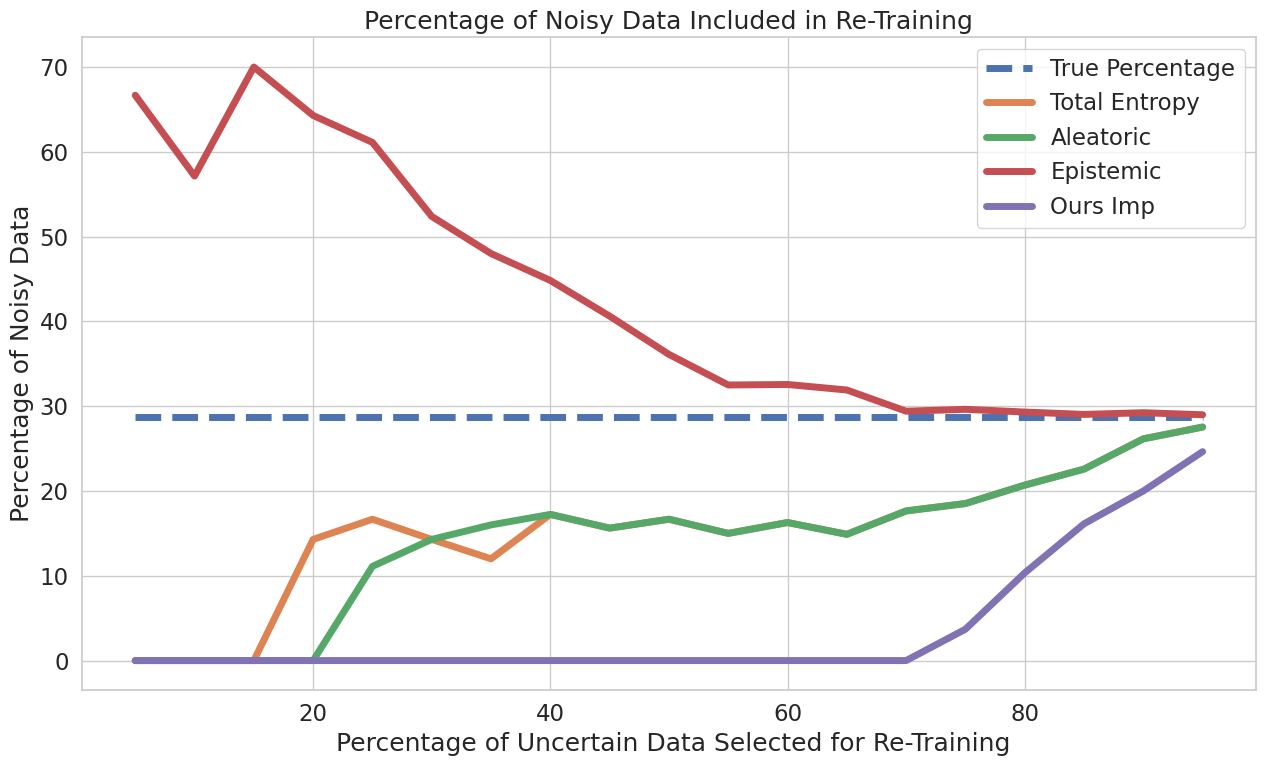

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", font_scale=1.5)

# Create the plot
plt.figure(figsize=(13, 8))
plt.plot(percentages, true_totals, label="True Percentage", linestyle='dashed',linewidth=5)
plt.plot(percentages, noisy_percentage_baseline_total, label="Total Entropy", linewidth=5)
plt.plot(percentages, noisy_percentage_baseline_a, label="Aleatoric", linewidth=5)
plt.plot(percentages, noisy_percentage_baseline_e, label="Epistemic", linewidth=5)
# plt.plot(percentages, noisy_percentage_concepts, label="Knowing Label Approach", linewidth=5)
plt.plot(percentages, noisy_percentage_top1_imp_concepts, label="Ours Imp", linewidth=5)
plt.plot(percentages, noisy_percentage_top1_nmf_concepts, label="Ours NMF", linewidth=5)
# plt.plot(percentages, noisy_percentage_top2_imp_concepts, label="Top 2 concept Imp", linewidth=5)
# plt.plot(percentages, noisy_percentage_top2_nmf_concepts, label="Top 2 concept NMF", linewidth=5)
# plt.plot(percentages, noisy_percentage_top3_imp_concepts, label="Top 3 concept Imp", linewidth=5)
# plt.plot(percentages, noisy_percentage_top3_nmf_concepts, label="Top 3 concept NMF", linewidth=5)



# Formatting
plt.xlabel(" Percentage of Uncertain Data Selected for Re-Training")
plt.ylabel("Percentage of Noisy Data")
plt.title("Percentage of Noisy Data Included in Re-Training")
plt.legend()
plt.tight_layout()

# Show plot
plt.show()

In [13]:
  # top1_imp_id_list = []
        # for i ,imp in enumerate(sig_im_imp):
        #     if np.argmax(imp) not in noisy_concepts:
        #         top1_imp_id_list.append(i)
        #         top1_imp_id_list = []
        top1_nmf_id_list = []
        for i ,imp in enumerate(sig_im_nmf_act):
            if np.argmax(imp) not in noisy_concepts:
                top1_nmf_id_list.append(i)
                
        # top2_imp_id_list = []
        # for i, imp in enumerate(sig_im_imp):
        #     # Get indices of top 3 most important concepts
        #     top_2_concepts = np.argsort(imp)[-2:]  # Last 3 indices are the most important
            
        #     # Check if any of them are in noisy_concepts
        #     if not any(concept in noisy_concepts for concept in top_2_concepts):
        #         top2_imp_id_list.append(i)
        
        # top2_nmf_id_list = []
        # for i ,imp in enumerate(sig_im_nmf_act):
        #     # Get indices of top 3 most important concepts
        #     top_2_concepts = np.argsort(imp)[-2:]  # Last 3 indices are the most important
            
        #     # Check if any of them are in noisy_concepts
        #     if not any(concept in noisy_concepts for concept in top_2_concepts):
        #         top2_nmf_id_list.append(i)
        
        # top3_imp_id_list = []
        # for i, imp in enumerate(sig_im_imp):
        #     # Get indices of top 3 most important concepts
        #     top_3_concepts = np.argsort(imp)[-3:]  # Last 3 indices are the most important
            
        #     # Check if any of them are in noisy_concepts
        #     if not any(concept in noisy_concepts for concept in top_3_concepts):
        #         top3_imp_id_list.append(i)
        
        # top3_nmf_id_list = []
        # for i ,imp in enumerate(sig_im_nmf_act):
        #     # Get indices of top 3 most important concepts
        #     top_3_concepts = np.argsort(imp)[-3:]  # Last 3 indices are the most important
            
        #     # Check if any of them are in noisy_concepts
        #     if not any(concept in noisy_concepts for concept in top_3_concepts):
        #         top3_nmf_id_list.append(i)

label_id_list = []
        for i ,image in enumerate(shuffled_images[med_indices]):
            nmf_act = np.array([nmf_transform(torch.unsqueeze(image,dim=0).cpu().numpy(),unc_basis) 
                                   for image in activations[i*num_patches_per_image:(i+1)* num_patches_per_image]])
            nmf_act =  nmf_act.reshape((len(nmf_act), nmf_act.shape[2]))
            preds = clf.predict(nmf_act)
            if sum(preds) < .95 * num_patches_per_image:
                label_id_list.append(i)

IndentationError: unexpected indent (2573058217.py, line 6)